In [1]:
import os

import random

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box


bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    "Tehran": {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    "Frankfurt": {"minx": 8.55, "miny": 50.00, "maxx": 8.80, "maxy": 50.20},
    "Aachen": {"minx": 6.05, "miny": 50.70, "maxx": 6.10, "maxy": 50.80},
    "Istanbul": {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20}

}

foldernames = {
    "Tehran": "iran-latest-free.shp",
    "Istanbul": "turkey-latest-free.shp",
    "Darmstadt": "hessen-latest-free.shp",
}

In [2]:
def save_file(foldername_out, city, color_sets):


    def load_stuff():
        shp_folder = foldernames[city]

        bounding_box_size = bounding_boxes[city]

        # Create a bounding box as a GeoDataFrame
        bounding_box = gpd.GeoDataFrame(
            {"geometry": [box(bounding_box_size["minx"], bounding_box_size["miny"], bounding_box_size["maxx"], bounding_box_size["maxy"])]}, 
            crs="EPSG:4326"  # WGS84 coordinate system
        )

        # Function to load only the data intersecting the bounding box
        def load_filtered_data(filepath, bounding_box):
            gdf = gpd.read_file(filepath, mask=bounding_box)
            return gdf


        railroads_path = shp_folder + "/gis_osm_railways_free_1.shp"

        normal_roads_path = shp_folder + "//gis_osm_roads_free_1.shp"

        # primary_roads_path = "turkey-latest-free.shp//gis_roads_primary.shp"

        landuse_path = shp_folder + "//gis_osm_landuse_a_free_1.shp"
        waterways_path = shp_folder + "//gis_osm_waterways_free_1.shp"
        water_path = shp_folder + "//gis_osm_water_a_free_1.shp"


        print("Read files")
        # Load shapefiles
        railroads = load_filtered_data(railroads_path, bounding_box)

        normal_roads = load_filtered_data(normal_roads_path, bounding_box)
        primary_roads = normal_roads.loc[normal_roads["fclass"]=="primary"]
        water = load_filtered_data(water_path, bounding_box)

        landuse = load_filtered_data(landuse_path, bounding_box)
        waterways = load_filtered_data(waterways_path, bounding_box)

        if city == "Istanbul":
            geoboundaries_path = "geoBoundaries-TUR-ADM0-all//geoBoundaries-TUR-ADM0.shp"


            # Load the provided shapefile
            geoboundaries = gpd.read_file(geoboundaries_path)

            # Reproject to EPSG:4326 if needed
            if geoboundaries.crs != "EPSG:4326":
                geoboundaries = geoboundaries.to_crs("EPSG:4326")
                print(f"Reprojected CRS: {geoboundaries.crs}")

            # Clip the geoboundaries using the bounding box
            clipped_geoboundaries = gpd.overlay(geoboundaries, bounding_box, how='intersection')
        else:
            clipped_geoboundaries = None

        print("Filter landuse")
        # Filter landuse based on fclass values
        landuse_filtered = landuse[landuse['fclass'].isin(['forest', 'park', 'farmland', 'meadow', 'allotments'])]

        return railroads, normal_roads, primary_roads, water, landuse_filtered, waterways, clipped_geoboundaries, bounding_box_size

    # Call the inner function to get the data
    railroads, normal_roads, primary_roads, water, landuse_filtered, waterways, clipped_geoboundaries, bounding_box_size = load_stuff()


    # Define the labels
    labels = ["bg", "road", "rail", "landscape", "land"]

    for idx, color_set in enumerate(color_sets):
        print(f"now using colorset {idx}")
        colors = {label: color_set[i] for i, label in enumerate(labels)}

        fig, ax = plt.subplots(figsize=(12, 12))


        bg_color = colors["bg"]
        road_color = colors["road"]
        rail_color = colors["rail"]
        landscape_color = colors["landscape"]
        land_color = colors["land"]
        water_color = colors["bg"]

        if city == "Istanbul":
            clipped_geoboundaries.plot(ax=ax, facecolor=land_color, linewidth=0, label="Country Boundaries")
        else:
            bg_color = land_color

        fig.patch.set_facecolor(bg_color)
        ax.set_facecolor(bg_color)

        landuse_filtered.plot(ax=ax, color=landscape_color)
        waterways.plot(ax=ax, color=water_color, linewidth=0.5)

        water.plot(ax=ax, color=water_color)

        normal_roads.plot(ax=ax, color=road_color, linewidth=0.1)
        primary_roads.plot(ax=ax, color=road_color, linewidth=0.2)

        railroads.plot(ax=ax, color=rail_color, linewidth=0.3)

        ax.set_xlim(bounding_box_size["minx"], bounding_box_size["maxx"])
        ax.set_ylim(bounding_box_size["miny"], bounding_box_size["maxy"])

        ax.axis('off')

        plt.savefig(foldername_out + city + f"_{idx}.pdf", dpi=300, bbox_inches='tight', facecolor=bg_color)
        plt.close()


In [5]:
# Define the color sets
color_sets_original = [
    ["#19535F", "#0B7A75", "#D7C9AA", "#7B2D26", "#F0F3F5"],
    ["#001514", "#FFFFFF", "#6B0504", "#A3320B", "#00A7E1"],
    ["#044389", "#FCFF4B", "#FFAD05", "#7CAFC4", "#5995ED"]
]


color_sets = []
for color_set in color_sets_original:
    for jdx in range(3):  # Generate 5 assignments
        shuffled_colors = color_set.copy()
        random.shuffle(shuffled_colors)  # Shuffle colors
        color_sets.append(shuffled_colors)

In [9]:
import random
from matplotlib import colors as mcolors

def generate_distinct_colors(n):
    # Get a large pool of distinct colors from matplotlib named colors
    all_colors = list(mcolors.CSS4_COLORS.values())
    random.shuffle(all_colors)  # Shuffle to ensure randomness
    
    color_sets = []
    for _ in range(n):
        # Randomly pick 5 unique colors
        color_set = random.sample(all_colors, 5)
        color_sets.append(color_set)
    return color_sets

# Generate 10 sets of 5 distinct colors
n = 30
color_sets = generate_distinct_colors(n)

# Display the color sets
color_sets


[['#DEB887', '#B22222', '#B8860B', '#FFE4E1', '#FFE4C4'],
 ['#FF0000', '#008000', '#DC143C', '#EEE8AA', '#B0E0E6'],
 ['#D3D3D3', '#FFFFE0', '#00BFFF', '#F5DEB3', '#FFF8DC'],
 ['#DAA520', '#FAFAD2', '#6495ED', '#FFF5EE', '#663399'],
 ['#F08080', '#D3D3D3', '#40E0D0', '#696969', '#FFA500'],
 ['#F0E68C', '#FFF5EE', '#CD853F', '#FFFFFF', '#FFF0F5'],
 ['#FFA500', '#F5F5DC', '#FFF0F5', '#F0FFF0', '#ADFF2F'],
 ['#228B22', '#FFA500', '#FFFFF0', '#DA70D6', '#808080'],
 ['#FFFFE0', '#C0C0C0', '#D3D3D3', '#FFF0F5', '#4169E1'],
 ['#FF0000', '#F0FFF0', '#6A5ACD', '#FF8C00', '#7FFFD4'],
 ['#4B0082', '#808080', '#7FFF00', '#FFFAF0', '#FFFACD'],
 ['#FF0000', '#87CEEB', '#00FF00', '#483D8B', '#808080'],
 ['#FF8C00', '#778899', '#3CB371', '#006400', '#F5FFFA'],
 ['#FAFAD2', '#FAEBD7', '#FFFAF0', '#006400', '#ADFF2F'],
 ['#2F4F4F', '#32CD32', '#006400', '#8B008B', '#98FB98'],
 ['#FFD700', '#FF00FF', '#4169E1', '#EEE8AA', '#32CD32'],
 ['#9370DB', '#FF6347', '#FFFAF0', '#FAEBD7', '#FA8072'],
 ['#7CFC00', '

In [10]:

foldername_out = input("Give your foldername") + "/"

os.mkdir(foldername_out)

for city in foldernames.keys():
    print(f"now calculating {city}")

    save_file(foldername_out, city,color_sets)


now calculating Tehran
Read files
Filter landuse
now using colorset 0
now using colorset 1
now using colorset 2
now using colorset 3
now using colorset 4
now using colorset 5
now using colorset 6
now using colorset 7
now using colorset 8
now using colorset 9
now using colorset 10
now using colorset 11
now using colorset 12
now using colorset 13
now using colorset 14
now using colorset 15
now using colorset 16
now using colorset 17
now using colorset 18
now using colorset 19
now using colorset 20
now using colorset 21
now using colorset 22
now using colorset 23
now using colorset 24
now using colorset 25
now using colorset 26
now using colorset 27
now using colorset 28
now using colorset 29
now calculating Istanbul
Read files
Filter landuse
now using colorset 0
now using colorset 1
now using colorset 2
now using colorset 3
now using colorset 4
now using colorset 5
now using colorset 6
now using colorset 7
now using colorset 8
now using colorset 9
now using colorset 10
now using colorset

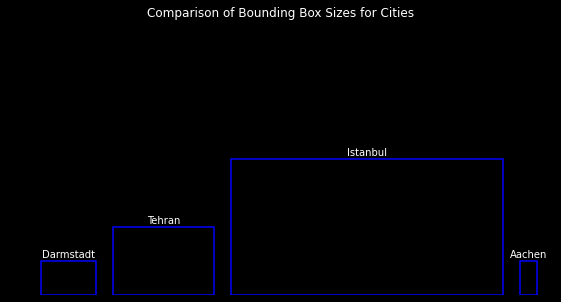

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define bounding boxes for the cities
bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    "Tehran": {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    "Istanbul": {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20},
    "Aachen": {"minx": 6.05, "miny": 50.70, "maxx": 6.10, "maxy": 50.80},
}

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Assign unique x-offsets for better visualization
x_offset = 0
for city, bbox in bounding_boxes.items():
    width = bbox["maxx"] - bbox["minx"]
    height = bbox["maxy"] - bbox["miny"]

    # Draw rectangle for the bounding box
    rect = patches.Rectangle(
        (x_offset, 0),  # Bottom-left corner of rectangle
        width,          # Width of rectangle
        height,         # Height of rectangle
        edgecolor="blue",
        facecolor="none",
        linewidth=1.5,
        label=city
    )
    ax.add_patch(rect)

    # Annotate city name
    ax.text(
        x_offset + width / 2,
        height + 0.01,
        city,
        ha="center",
        fontsize=10
    )
    
    # Increase x_offset for next rectangle
    x_offset += width + 0.05

# Adjust axes
ax.set_xlim(-0.1, x_offset)
ax.set_ylim(0, 0.8)
ax.set_aspect('equal')
ax.set_title("Comparison of Bounding Box Sizes for Cities")
ax.axis('off')

# Show plot
plt.show()


In [8]:
import folium
from shapely.geometry import box

# Define bounding boxes for the cities
bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    "Tehran": {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    "Istanbul": {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20},
    "Aachen": {"minx": 6.05, "miny": 50.70, "maxx": 6.10, "maxy": 50.80},
}

# Create a folium map for each city
maps = {}
for city, bbox in bounding_boxes.items():
    center_lat = (bbox["miny"] + bbox["maxy"]) / 2
    center_lon = (bbox["minx"] + bbox["maxx"]) / 2
    folium_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)

    # Draw the bounding box
    bounding_box_geom = box(bbox["minx"], bbox["miny"], bbox["maxx"], bbox["maxy"])
    folium.GeoJson(
        bounding_box_geom.__geo_interface__,
        style_function=lambda x: {"color": "blue", "weight": 2, "fillOpacity": 0},
    ).add_to(folium_map)

    # Store the map
    maps[city] = folium_map

# Display the maps for each city
for city, city_map in maps.items():
    print(f"Map for {city}")
    display(city_map)


Map for Darmstadt


Map for Tehran


Map for Istanbul


Map for Aachen


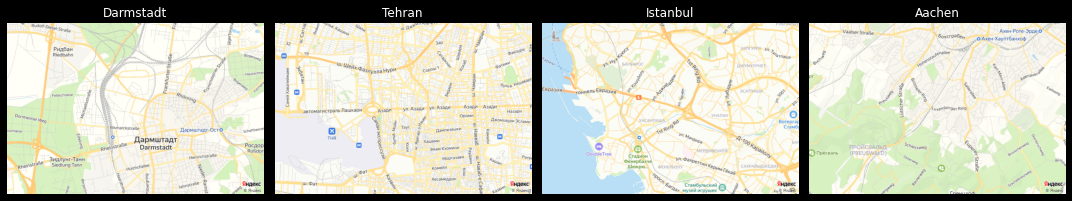

In [11]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Define bounding boxes for the cities
bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    "Tehran": {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    "Istanbul": {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20},
    "Aachen": {"minx": 6.05, "miny": 50.70, "maxx": 6.10, "maxy": 50.80},
}

# Static map base URL
static_map_url = "https://static-maps.yandex.ru/1.x/"

# Function to fetch static maps
def fetch_static_map(bbox, city, zoom=13, width=600, height=400):
    center_lat = (bbox["miny"] + bbox["maxy"]) / 2
    center_lon = (bbox["minx"] + bbox["maxx"]) / 2
    params = {
        "ll": f"{center_lon},{center_lat}",
        "z": zoom,
        "size": f"{width},{height}",
        "l": "map",
    }
    response = requests.get(static_map_url, params=params)
    image = Image.open(BytesIO(response.content))
    return image

# Fetch images for each city
images = {city: fetch_static_map(bbox, city) for city, bbox in bounding_boxes.items()}

# Plot the maps side by side
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for ax, (city, img) in zip(axes, images.items()):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(city)

plt.tight_layout()
plt.show()
